<a href="https://colab.research.google.com/github/hadisotudeh/product-color-classification/blob/main/ML%20model%20training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Product Color Classification

This project makes use of [FastAI](https://fast.ai) library to train a product color classifier on the [Digikala](https://digikala.com) product dataset released as part of their [data science](https://quera.ir/contest/assignments/20120/problems) competition.

In [1]:
!git clone https://github.com/hadisotudeh/product-color-classification.git
!pip install fastai --upgrade

fatal: destination path 'product-color-classification' already exists and is not an empty directory.
Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (2.1.7)


In [2]:
#hide
from fastai.vision.all import *
from PIL import Image

import os
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
train_path = Path("train")
test_path = Path("test")
split_index = 1

In [4]:
# run this cell if you are using google colab
repo_path = Path('product-color-classification')
train_path = Path.joinpath(repo_path, "train")
test_path = Path.joinpath(repo_path, "test")
split_index = 2

In [5]:
fns = get_image_files(train_path)
failed = verify_images(fns)
failed.map(train_path.unlink)

(#0) []

In [6]:
def get_color(file_path): return str(file_path).split("/")[split_index] 

dls = ImageDataLoaders.from_path_func(train_path, get_image_files(train_path), 
                                      label_func=get_color, seed=42, valid_pct=0.2,
                                      item_tfms=Resize(460), batch_tfms=aug_transforms(size=224, min_scale=0.75))

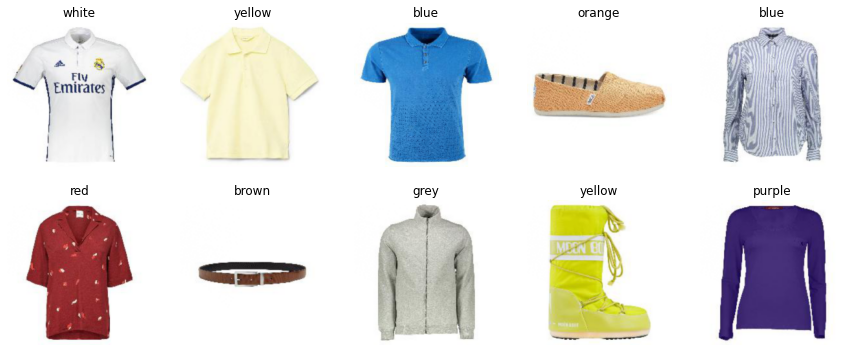

In [7]:
dls.valid.show_batch(max_n=10, nrows=2)

In [8]:
learn = cnn_learner(dls, resnet101, metrics=accuracy)

learn.fine_tune(10, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,time
0,1.915691,1.099210,0.686448,01:30
1,1.303200,1.039511,0.710505,01:27
2,1.043673,0.920086,0.749799,01:27


KeyboardInterrupt: ignored

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

In [ ]:
interp.most_confused(5)

In [ ]:
interp.plot_top_losses(10, nrows=2)